In [1]:
CENTER = "UVA"
DATA_ROOT = "/mnt/data2/paul/cores_dataset"

from exactvu.data.splits import get_splits

train, val, test = get_splits("UVA")
all_core_specifiers = train + val + test

from exactvu.client import check_prostate_mask_exists

from tqdm import tqdm

all_core_specifiers = [
    spec for spec in tqdm(all_core_specifiers) if not check_prostate_mask_exists(spec)
]

from exactvu.data import Core

cores = [
    Core(spec, "/mnt/data2/paul/cores_dataset/") for spec in tqdm(all_core_specifiers)
]

100%|██████████| 511/511 [00:00<00:00, 279183.19it/s]


FloatSlider(value=0.5, max=1.0, step=0.02)

Output()

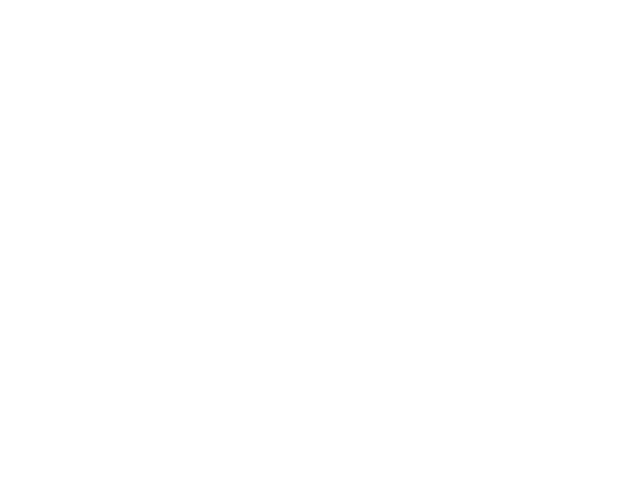

In [2]:
%matplotlib widget

from src.interactive import run
run(cores)

In [4]:
%matplotlib widget

In [99]:
import cv2
from PIL import Image

def get_masked_image(bmode, mask):

    colored = cv2.cvtColor(bmode, cv2.COLOR_GRAY2RGB)
    colored_uint8 = cv2.normalize(colored, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    Image.fromarray(colored_uint8)

    img = mask 
    color = np.array([102, 204, 0]).astype('uint8')
    color = np.expand_dims(color, 0)
    color = np.expand_dims(color, 0)
    color = np.expand_dims(mask, -1) * color

    out = cv2.addWeighted(colored_uint8, 0.7, color, 0.3, 20)

    return out

In [12]:
bmode = cv2.normalize(bmode, a)

array([[7.39850232, 7.16946378, 6.63139004, ..., 7.93443349, 7.17538321,
        6.40283668],
       [7.21368368, 7.38402851, 7.72822475, ..., 7.96302973, 7.88610611,
        7.59156119],
       [6.46918462, 7.13446168, 7.63915221, ..., 7.17688268, 6.8699273 ,
        6.60391822],
       ...,
       [2.86270639, 3.58897415, 3.9053951 , ..., 3.99221983, 3.94360666,
        3.25162671],
       [2.5483591 , 3.0379618 , 2.7504631 , ..., 1.25936093, 3.74052695,
        3.74030306],
       [4.08762397, 3.63932655, 2.48152313, ..., 2.95026532, 3.33432337,
        3.77639411]])

In [15]:

from ipywidgets import Output, Text, Button, Label, HBox, interact, FloatSlider
from IPython.display import display
import numpy as np
from exactvu.data import Core
import matplotlib
import matplotlib.pyplot as plt
import cv2
from matplotlib.colors import ListedColormap
from exactvu.client import check_prostate_mask_exists, load_prostate_mask, add_prostate_mask, load_prostate_mask_probs

idx: int = 0
bmode: np.ndarray 
probs: np.ndarray
mask: np.ndarray
core_specifier: str
core: Core
output: Output
threshold_prob: float = 0.5

title = Text(   value=None,
                placeholder='Type something',
                description='Core:',
                disabled=True
            )
message = Text(
    value=None, 
    disabled = True
)
count = Text(
    value=str(len(cores)),
    description='Cores left'
)
title_bar = HBox([title, message, count])

back_button = Button(description='Go Back', button_style='info')
save_button = Button(description='Save Mask', button_style='success')
overwrite_button = Button(description='Overwrite Mask', button_style='danger')
next_button = Button(description='Next', button_style='info')

buttons = HBox([back_button, save_button, overwrite_button, next_button,])

output = Output()

with output:
    plt.clf()
    plt.ioff()
    fig, ax = plt.subplots()
    plt.ion()
    bmode_imshow = ax.imshow(np.zeros((256, 256)), vmin=0, vmax=255, cmap='gray')
    mask_imshow = ax.imshow(np.zeros((256, 256)), alpha=0.5, cmap=ListedColormap('green'))
    plt.axis('off')
    plt.ioff()
    fig.show()
    plt.ion()

def compute():
    if core is None: 
        return 

    global bmode 
    bmode = core.bmode
    bmode = cv2.normalize(bmode, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    assert bmode is not None
    global probs 
    probs = load_prostate_mask_probs(core.specifier)
    
threshold_slider = FloatSlider(value=0.5, min=0, max=1, step=0.02)

def update_threshold(change):
    with output: 
        t = change['new']
        global threshold_prob 
        threshold_prob = t

        with output: 
            mask_imshow.set_data(np.where(probs >= threshold_prob, 1, np.nan))
            fig.canvas.draw_idle()

threshold_slider.observe(update_threshold, 'value')

def update_image_display(): 
    img = get_masked_image(bmode, mask)
    Image.fromarray(img)

def render(): 

    global core 
    core = cores[idx] 
    global title
    title.value = core.specifier

    if idx + 1 == len(cores):
        next_button.disabled = True 
    else: 
        next_button.disabled = False

    if idx == 0: 
        back_button.disabled = True 
    else: 
        back_button.disabled = False 

    if check_prostate_mask_exists(core.specifier):
        overwrite_button.disabled = False 
        save_button.disabled = True 
    else: 
        overwrite_button.disabled = True
        save_button.disabled = False
    
    message.value = ''

    compute()
    with output:
        print(bmode) 
        bmode_imshow.set_data(bmode)
        mask_imshow.set_data(np.where(probs >= threshold_prob, 1, np.nan))
        fig.canvas.draw_idle()

def save(b):
    try: 
        add_prostate_mask(core.specifier, probs >= threshold_prob)
        count.value = str(int(count.value) - 1)
        next(b)
    except: 
        message.value = 'Error occurred when saving'

def overwrite(b):
    try: 
        add_prostate_mask(core.specifier, probs >= threshold_prob, overwrite=True)
        message.value = 'Overwrite successful.'   
    except: 
        message.value = 'Error occurred while overwriting'

save_button.on_click(save)
overwrite_button.on_click(overwrite)

def next(b):
    global idx  
    idx += 1 
    render()

next_button.on_click(next)

def back(b): 
    global idx 
    idx -= 1 
    render()

back_button.on_click(back)

display(title_bar, buttons, threshold_slider, output,)
render()


FloatSlider(value=0.5, max=1.0, step=0.02)

Output()

[[146 162 173 ... 190 180 166]
 [185 164 183 ... 183 183 190]
 [138 163 165 ... 192 190 176]
 ...
 [ 99  86  67 ...  85  77  98]
 [ 90  95  94 ...  78  70  64]
 [ 79  82  73 ...  84  81  73]]


In [46]:
bmode

array([[ 0.14901972,  0.38431382,  0.54117656, ...,  0.18039227,
         0.32156873,  0.30588245],
       [-0.05490196,  0.21176481,  0.47843146, ...,  0.43137264,
         0.5254903 ,  0.337255  ],
       [ 0.13333344,  0.25882363,  0.41568637, ...,  0.4000001 ,
         0.30588245,  0.18039227],
       ...,
       [-1.6235294 , -1.5450981 , -1.4196079 , ..., -1.6862745 ,
        -1.7803922 , -1.5294118 ],
       [-1.1215687 , -1.1843138 , -1.2       , ..., -1.6078432 ,
        -1.7176471 , -1.4980392 ],
       [-1.0588236 , -1.2313726 , -1.3882353 , ..., -1.6235294 ,
        -1.6705883 , -1.5137255 ]], dtype=float32)

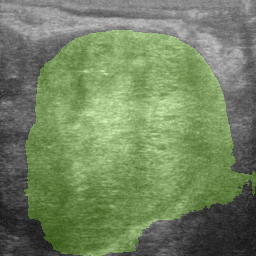

In [98]:
import cv2
from PIL import Image

def get_masked_image(bmode, mask):

    colored = cv2.cvtColor(bmode, cv2.COLOR_GRAY2RGB)
    colored_uint8 = cv2.normalize(colored, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    Image.fromarray(colored_uint8)

    img = mask 
    color = np.array([102, 204, 0]).astype('uint8')
    color = np.expand_dims(color, 0)
    color = np.expand_dims(color, 0)
    color = np.expand_dims(mask, -1) * color

    out = cv2.addWeighted(colored_uint8, 0.7, color, 0.3, 20)

    return out



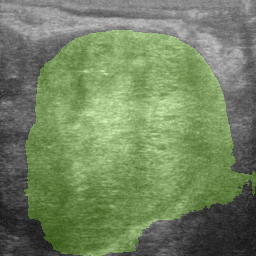

In [111]:
Image.fromarray(out)

In [108]:
output.append_display_data()

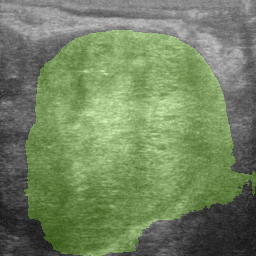

In [115]:
from IPython.display import Image as DispImage
DispImage('mask.png')

In [114]:
Image.fromarray(out).save('mask.png')

In [136]:
success, buffarr = cv2.imencode('.jpg', out)
bytes = buffarr.tobytes()
im = DispImage(bytes, format='jpg')

In [148]:
im.data = bytes
im.

In [135]:
output.clear_output()

In [ ]:
output.

In [144]:
output.clear_output()
output.append_display_data(im)

In [141]:
output

Output()

In [152]:
output

Output()

In [154]:
output.

TypeError: add_class() missing 1 required positional argument: 'className'

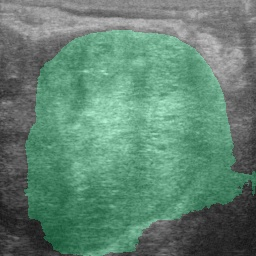

In [109]:
output

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': 'None'}, 'metadata': {}}, {'output_type…

In [92]:
color

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

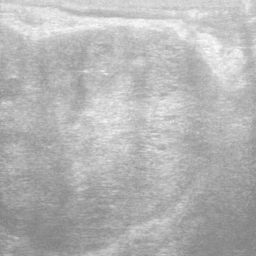

In [87]:
colored = cv2.cvtColor(bmode, cv2.COLOR_GRAY2RGBA)
colored_uint8 = cv2.normalize(colored, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
colored_uint8[..., -1] = 128
Image.fromarray(colored_uint8)

In [88]:
mask = probs >= 0.5

In [89]:
img = mask 
color = np.array([102, 204, 0]).astype('uint8')
color = np.expand_dims(color, 0)
color = np.expand_dims(color, 0)
color = np.expand_dims(mask, -1) * color

mask_alpha = 0.5
alpha = np.where(mask, 255 - 128, int(255 * mask_alpha)).astype('uint8')
alpha = np.expand_dims(alpha, -1)

colored_mask = np.concatenate([color, alpha], axis=-1)


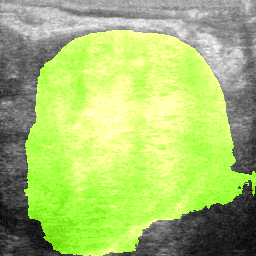

In [90]:
masked_image = cv2.add(colored_uint8, colored_mask)
Image.fromarray(masked_image)

In [78]:
alpha.shape

(256, 256, 1)

In [82]:
color.shape

(256, 256, 3)

In [72]:
colored_mask

array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       ...,

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0

In [42]:
color = np.array([102, 204, 0]).reshape(1, 1, -1).astype('uint8')
mask = colored_mask * color
mask = np.where(colored_mask)
transp = 1 - colored_mask

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 4 dimension(s)

In [44]:
colored_mask.shape

(256, 256, 3, 1)

In [39]:
out = cv2.addWeighted(colored_uint8, 0.5, mask, 0.5, 0)

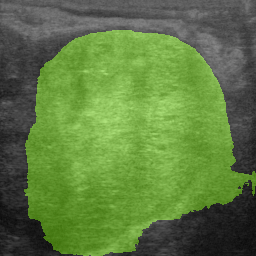

In [40]:
Image.fromarray(out)

In [22]:
colored_uint8.shape

(256, 256, 3)

In [155]:
import tkinter as tk 

tk.Tk()

TclError: no display name and no $DISPLAY environment variable